In [264]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,precision_recall_curve, f1_score,make_scorer, fbeta_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier



In [292]:
df = pd.read_csv("data/datatrain.csv")
X = df.select_dtypes(include=["number"]).drop(columns=["target","Created At Year","Countries_ID","Created At Month","visit_std_days","visit_count_days","badge_activity_count"])
# X = df[cols]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [242]:
X

,FeatureX,FeatureY,Created At Day_of_month,days_left_in_month,visit_count_days,visit_std,visit_count,job_activity_count,comp_activity_count,blog_activity_count,...,subm count 10,subm count 3,subm count 8,subm count 9,subm count 6,subm count 7,subm count 5,subm count 4,comments_count,discussions_count
0,0,0,16,14,1,0.0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,27,4,2,0.0,25,1,3,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,29,2,2.0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,27,4,2,0.0,23,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,16,14,8,3.0,62,0,14,1,...,1,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9063,0,1,7,23,2,9.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9064,0,1,6,24,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9065,0,1,25,6,1,0.0,12,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9066,0,1,7,24,9,5.0,26,0,8,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
from sklearn.ensemble import RandomForestClassifier
clfb = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=4,
    random_state=42,
    #class_weight='balanced'
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=4,
    random_state=42,
    class_weight='balanced'
)


In [295]:
catclf = CatBoostClassifier(n_estimators=2000,learning_rate=0.01124,
    auto_class_weights='Balanced')


In [283]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, beta=1):
    """
    Trains the model, evaluates default and optimal threshold, and plots results.
    """
    model.fit(X_train, y_train,early_stopping_rounds=100,verbose=100)
    print("Model training complete.")

    y_pred_default = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_predtrain_default = model.predict(X_train)
    print(classification_report(y_test, y_pred_default, labels=[0, 1]))
    print(classification_report(y_train, y_predtrain_default, labels=[0, 1]))
    return model
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"The ROC AUC score is: {auc:.4f}")

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    #plt.show()

    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, marker='.', label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    #plt.show()

    # Find optimal threshold using F2-score
    f2_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-9)

    optimal_idx = np.argmax(f2_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal threshold found: {optimal_threshold:.4f}")
    print(f"This threshold gives a Precision of {precision[optimal_idx]:.4f} and a Recall of {recall[optimal_idx]:.4f}")

    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    #print(classification_report(y_test, y_pred_optimal, labels=[0, 1]))
    #print(classification_report(y_train, y_predtrain_proba, labels=[0, 1]))
    f2 = fbeta_score(y_test, y_pred_optimal, beta=2)
    print(f"F2 Score: {f2:.4f}")
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted No Fraud', 'Predicted Fraud'],
                yticklabels=['Actual No Fraud', 'Actual Fraud'])
    plt.title('Confusion Matrix with Optimal Threshold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [296]:
ranb = train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, clfb)
ran = train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, clf)

TypeError: BalancedRandomForestClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [297]:
cat = train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, catclf)

0:	learn: 0.6903484	total: 7.49ms	remaining: 15s
100:	learn: 0.5692603	total: 767ms	remaining: 14.4s
200:	learn: 0.5410097	total: 1.58s	remaining: 14.2s
300:	learn: 0.5258971	total: 2.3s	remaining: 13s
400:	learn: 0.5159839	total: 3.05s	remaining: 12.2s
500:	learn: 0.5078061	total: 3.72s	remaining: 11.1s
600:	learn: 0.5007647	total: 4.41s	remaining: 10.3s
700:	learn: 0.4938634	total: 5.37s	remaining: 9.96s
800:	learn: 0.4852964	total: 6.1s	remaining: 9.13s
900:	learn: 0.4747448	total: 7.06s	remaining: 8.61s
1000:	learn: 0.4642926	total: 7.76s	remaining: 7.74s
1100:	learn: 0.4549899	total: 8.47s	remaining: 6.92s
1200:	learn: 0.4470590	total: 9.05s	remaining: 6.02s
1300:	learn: 0.4390287	total: 9.7s	remaining: 5.21s
1400:	learn: 0.4319070	total: 10.4s	remaining: 4.44s
1500:	learn: 0.4244231	total: 11s	remaining: 3.65s
1600:	learn: 0.4173895	total: 11.8s	remaining: 2.95s
1700:	learn: 0.4104809	total: 12.5s	remaining: 2.2s
1800:	learn: 0.4035190	total: 13.2s	remaining: 1.46s
1900:	learn: 0

In [298]:
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top_n most significant features based on feature importance from a fitted model.
    Args:
        model: Trained tree-based model with feature_importances_ attribute.
        feature_names: List of feature names.
        top_n: Number of top features to display.
    """
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    top_features = feat_imp.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    top_features.plot(kind='barh')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print(top_features)
    return top_features.index

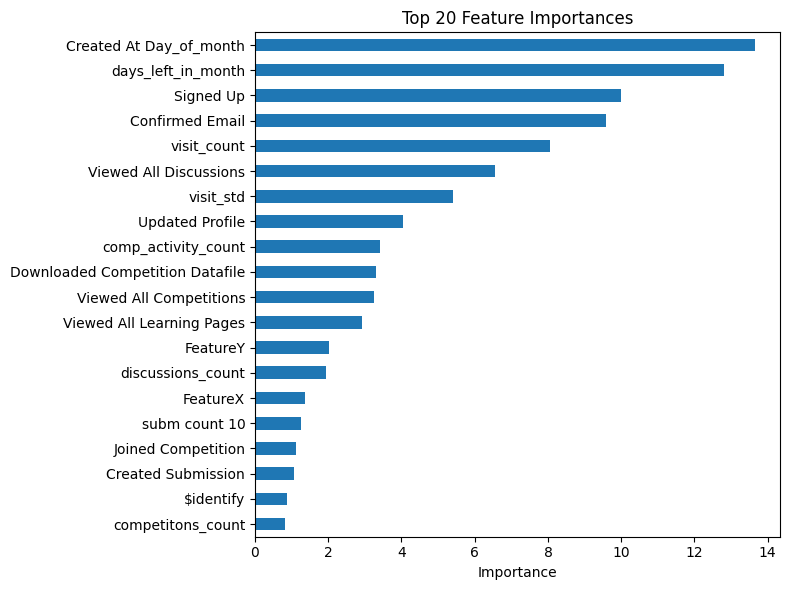

Created At Day_of_month            13.653748
days_left_in_month                 12.816735
Signed Up                           9.992950
Confirmed Email                     9.595977
visit_count                         8.054931
Viewed All Discussions              6.554701
visit_std                           5.412613
Updated Profile                     4.035201
comp_activity_count                 3.419887
Downloaded Competition Datafile     3.299334
Viewed All Competitions             3.255011
Viewed All Learning Pages           2.918628
FeatureY                            2.026421
discussions_count                   1.944078
FeatureX                            1.366520
subm count 10                       1.248420
Joined Competition                  1.126344
Created Submission                  1.077926
$identify                           0.878578
competitons_count                   0.821312
dtype: float64


In [299]:
cols = plot_feature_importance(catclf, X.columns, top_n=20)

In [248]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
xgb = XGBClassifier(
    n_estimators=100,        # trees, tune with early stopping
    learning_rate=0.05,      # conservative, allows more trees
    max_depth=6,             # controls complexity
    min_child_weight=1,      # larger -> more conservative splits
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    reg_lambda=1,            # L2 regularization
    reg_alpha=0,             # L1 regularization
    scale_pos_weight=scale_pos_weight,      # adjust if imbalance exists (see below)
    objective="binary:logistic",
    eval_metric="logloss",   # use logloss during training
    random_state=42,
    n_jobs=-1,
    
)


In [249]:

xgb = train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, xgb)

Model training complete.
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1323
           1       0.69      0.79      0.74       491

    accuracy                           0.85      1814
   macro avg       0.80      0.83      0.81      1814
weighted avg       0.86      0.85      0.85      1814

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5293
           1       0.75      0.84      0.79      1961

    accuracy                           0.88      7254
   macro avg       0.84      0.87      0.85      7254
weighted avg       0.89      0.88      0.88      7254



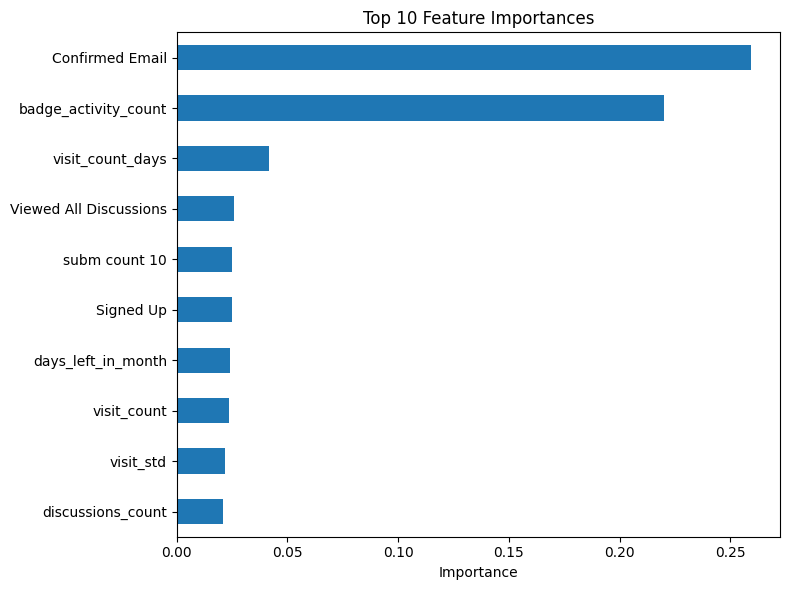

Confirmed Email           0.259379
badge_activity_count      0.220135
visit_count_days          0.041554
Viewed All Discussions    0.025925
subm count 10             0.024860
Signed Up                 0.024733
days_left_in_month        0.023831
visit_count               0.023721
visit_std                 0.021934
discussions_count         0.020972
dtype: float32


Index(['Confirmed Email', 'badge_activity_count', 'visit_count_days',
       'Viewed All Discussions', 'subm count 10', 'Signed Up',
       'days_left_in_month', 'visit_count', 'visit_std', 'discussions_count'],
      dtype='object')

In [250]:
plot_feature_importance(xgb, X.columns, top_n=10)

In [300]:
test_df = pd.read_csv("data/datatest.csv")

In [302]:
X = test_df.select_dtypes(include=["number"]).drop(columns=["Created At Year","Countries_ID","Created At Month","visit_std_days","visit_count_days","badge_activity_count"])
# X = test_df[cols]
X_scaled = scaler.transform(X)

In [ ]:
predictions = xgb.predict(X_scaled)
predictions2 = clf.predict(X_scaled)
predictions3 = clfb.predict(X_scaled)


ValueError: Feature shape mismatch, expected: 55, got 53

In [303]:
predictionscat = cat.predict(X_scaled)

In [304]:
predictionscat.sum()

np.int64(199)

In [310]:
sub = pd.DataFrame({
    'User_ID_Next_month_Activity': test_df.User_ID,
    'Active': predictions
})

sub2 = pd.DataFrame({
    'User_ID_Next_month_Activity': test_df.User_ID,
    'Active': predictions2
})
sub3 = pd.DataFrame({
    'User_ID_Next_month_Activity': test_df.User_ID,
    'Active': predictionscat
})

In [311]:
sub.User_ID_Next_month_Activity = sub.User_ID_Next_month_Activity + '_Month_5'
sub2.User_ID_Next_month_Activity = sub2.User_ID_Next_month_Activity + '_Month_5'
sub3.User_ID_Next_month_Activity = sub3.User_ID_Next_month_Activity + '_Month_5'

In [312]:
SampleSubmission = pd.read_csv("data/SampleSubmission.csv")

In [313]:
sub = pd.merge(SampleSubmission.drop(columns='Active'), sub, on='User_ID_Next_month_Activity', how='left').fillna(0)
sub2 = pd.merge(SampleSubmission.drop(columns='Active'), sub2, on='User_ID_Next_month_Activity', how='left').fillna(0)
sub3 = pd.merge(SampleSubmission.drop(columns='Active'), sub3, on='User_ID_Next_month_Activity', how='left').fillna(0)

In [314]:
sub.to_csv("xgb_submission.csv", index=False)
sub2.to_csv("rf_submission.csv", index=False)
sub3.to_csv("cat_submission.csv", index=False)